In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


In [75]:
# leer el dataset databici.csv 
df = pd.read_csv('databici.csv', parse_dates=['dteday'], index_col='instant')
display(df)
df.info()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 1 to 17379
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      17379 non-null  datetime64[ns]
 1   season      17379 non-null  int64         
 2   yr          17379 non-null  int64         
 3   mnth        17379 non-null  int64         
 4   hr          17379 non-null  int64         
 5   holiday     17379 non-null  int64         
 6   weekday     17379 non-null  int64         
 7   workingday  17379 non-null  int64         
 8   weathersit  17379 non-null  int64         
 9   temp        17379 non-null  float64       
 10  atemp       17379 non-null  float64       
 11  hum         17379 non-null  float64       
 12  windspeed   17379 non-null  float64       
 13  casual      17379 non-null  int64         
 14  registered  17379 non-null  int64         
 15  cnt         17379 non-null  int64         
dtypes: datetime64[ns](1), 

## 1. ¿Qué rango de hora es la de mayor demanda?

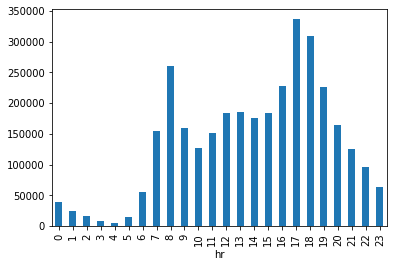

La mayor demanda es a las: 17.0


In [22]:
## 1. ¿Qué rango de hora es la de mayor demanda?
por_hora = df.groupby('hr').sum()
por_hora['cnt'].plot(kind='bar')
plt.show()
print('La mayor demanda es a las:', por_hora.reset_index().sort_values('cnt', ascending=False).iloc[0]['hr'])


## 2. ¿Qué temporada es la mas alta?

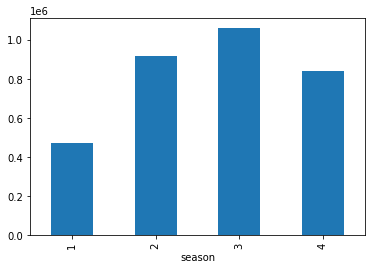

La mayor demanda es a las: 3.0


In [23]:
# 2. ¿Qué temporada es la mas alta?
por_temporada = df.groupby('season').sum()
por_temporada['cnt'].plot(kind='bar')
plt.show()
print('La mayor demanda es en la temporada:', por_temporada.reset_index().sort_values('cnt', ascending=False).iloc[0]['season'])

## Para responder las preguntas 3 a 5 debemos explorar los datos y crear un modelo de regresión


### Exploracion de los datos:

<AxesSubplot:>

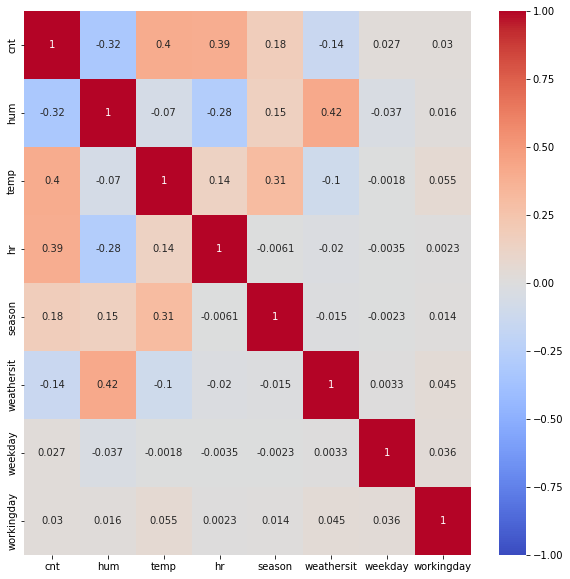

In [55]:
# correlaciones
corr = df[['cnt', 'hum', 'temp', 'hr', 'season', 'weathersit']].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

No existe una gran correlacion de variables, las mas adecuadas podrían ser humedad, temperatura y hora

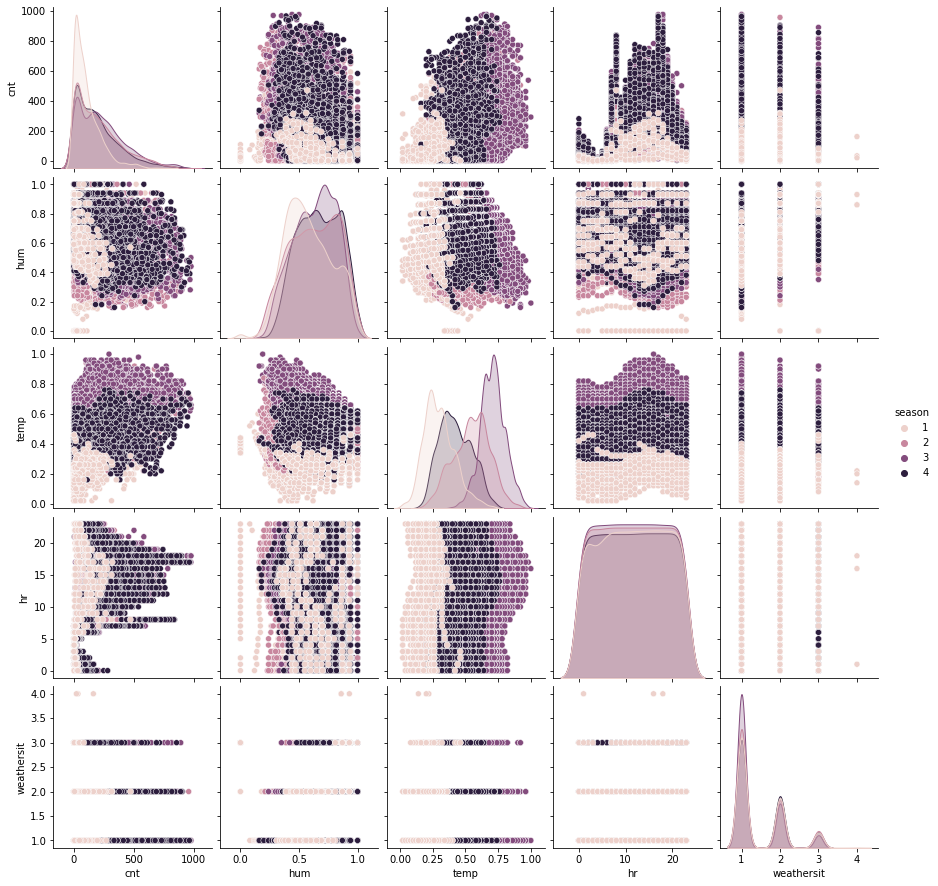

In [76]:
# plot de las distribuciones
df2 = df[['cnt', 'hum', 'temp', 'season', 'hr', 'weathersit']]
sns.pairplot(df2, hue="season")

Tampoco observamos relaciones lineales viendo las distribuciones

### Creacion del modelo

In [133]:
# crear el modelo lineal
model = linear_model.LinearRegression()

# crear el dataset de entrenamiento
mask = np.random.rand(len(df))<0.8
train = df[mask]
test = df[~mask]

# entrenar
regresores = ['temp', 'hum']
regr = model.fit(train[regresores], train['cnt'])

# predecir
test = test.copy()
test['predict'] = regr.predict(test[regresores])

# valores
print('intercepto: ', regr.intercept_)
print('coeficientes: ', regr.coef_)
print('r2: ', r2_score(test['cnt'], test['predict']))


intercepto:  184.37682041238529
coeficientes:  [ 363.16836682 -280.26266333]
r2:  0.24909212928489033


Un primer modelo creado solo con la humedad y temperatura no pareciera ser la mejor solución posible

Deberíamos tratar con mas regresores

In [151]:
# funcion para buscar el modelo lineal con mejor precision que el anterior
def entrenar(data, dependiente, regresores, intentos=20, ratio=0.8):
    model2 = linear_model.LinearRegression()
    score = 0
    model = None

    for i in range(intentos):
        # crear el dataset de entrenamiento
        mask = np.random.rand(len(df)) < ratio
        train = data[mask]
        test = data[~mask]
        regr = model2.fit(train[regresores], train[dependiente]) 
        test = test.copy()
        test['predict'] = regr.predict(np.asanyarray(test[regresores]))

        # check de score
        if score <= r2_score(test['cnt'], test['predict']):
            score = r2_score(test['cnt'], test['predict'])
            model = regr

    # valores
    print('intercepto: ', regr2.intercept_)
    print('coeficientes: ', regr2.coef_)
    print('r2: ', r2_score(test['cnt'], test['predict']))

    return model

In [153]:
## preparar variables
# weathersit parece tener un poco de relación cuando es 1
df['ws1'] = df['weathersit']==1

# la humedad y la temperatura en conjunto podrían influir en la demanda
df['hum_temp'] = df['hum']*df['temp']

# la temporada y la hora deberían influir en la demanda
df['season_hr'] = df['season']*df['hr']

# parametros
regresores = ['temp', 'hum', 'season', 'hr', 'ws1', 'hum_temp', 'season_hr']
dependiente = 'cnt'

regr2 = entrenar(df, dependiente, regresores)

# usar el modelo
df2 = df.copy()
df2['prediction'] = regr2.predict(df[regresores])


intercepto:  -48.78552813962315
coeficientes:  [ 601.24442538   24.80769636    1.42688822    3.56768905   -3.87118631
 -524.17612969    1.53538454]
r2:  0.3609438474539244


/home/dennis/.cache/pypoetry/virtualenvs/pythondata-ElkPyzMM-py3.9/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Usando mas variables y reintentando el entrenamiento 10 veces logramos un r2score de al rededor de 0.35

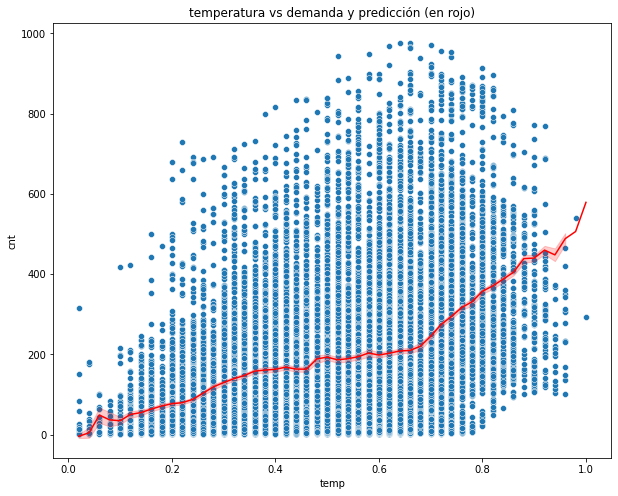

In [148]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='temp', y='cnt', data=df2)
sns.lineplot(x='temp', y='prediction', data=df2, color='red').set(title='temperatura vs demanda y predicción (en rojo)')
plt.show()

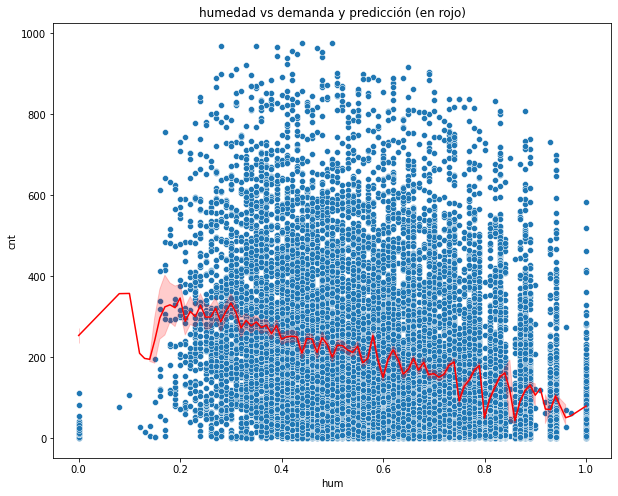

In [149]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='hum', y='cnt', data=df2)
sns.lineplot(x='hum', y='prediction', data=df2, color='red').set(title='humedad vs demanda y predicción (en rojo)')
plt.show()

In [150]:
df2[['cnt', 'prediction', 'hum', 'temp']].sort_values('prediction', ascending=False).head(10)

,cnt,prediction,hum,temp
instant,,,,
13164,294,578.953488,0.19,1.00
4988,320,561.438569,0.16,0.92
4987,306,549.043229,0.17,0.92
4986,293,536.647889,0.18,0.92
13165,279,535.103410,0.26,0.96
13166,277,520.443480,0.29,0.94
12974,464,519.907198,0.31,0.96
13163,306,519.186448,0.26,0.96
13021,413,517.069981,0.26,0.92


## 3. ¿Es la temperatura relevante para el modelo?

En general sí, ya que a bajas temperaturas hay baja demanda, pero no existe una relación lineal.


## 4. ¿Es la humedad relevante para el modelo?

La misma respuesta anterior, solo que en este caso la relación es inversa (a mas humedad menos demanda).


## 5. ¿Qué condiciones serian ideales para nuestra demanda?

Mediante este modelo sería a temperatura 1.00 y humedad 0.19, pero es difícil tomarlo en cuenta ya que el mejor score r2 obtenido es tan solo de 0.35, podríamos decir que en general la temperatura juega un papel directamente proporcional y la humedad inversamente proporcional.
